## Quantum walk operator for the case of a line with 16 nodes

A quantum walk is the quantum analog of a classical random walk, but it leverages the principles of quantum mechanics such as superposition, interference, and entanglement. Quantum walks can occur on discrete structures like graphs (discrete-time quantum walks) or in continuous space (continuous-time quantum walks).

## Quantum Walk on a Line(Discrete-Time Quantum Walks)

 - Initialization: The walker starts at an initial position, which could be at one node or in a superposition of nodes.
 - Coin Flip: A quantum "coin" is flipped, creating a superposition of moving left or right.
 - Step: Depending on the outcome of the coin flip, the walker moves to an adjacent node.
 - Iteration: This process is repeated, with the walker’s position evolving into a quantum superposition over many nodes, with complex interference patterns determining the probability of finding the walker at any particular node.
 
 The process typically involves two main operations:

 - Coin Flip (C Operator): A unitary operation is applied to the coin qubit, creating a superposition of directions (e.g., left or right).
 
 
 - Shift Operation (S Operator): The walker's position is updated based on the result of the coin flip, often moving the walker to adjacent nodes on the graph.

In [2]:
!pip install -U classiq
import classiq
# classiq.authenticate()

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.


  Obtaining dependency information for classiq from https://files.pythonhosted.org/packages/2b/f4/b3d4969d90af15bc524e4af9d7f7a2b50f9115ac0c5a7de6622c1c4e6c20/classiq-0.45.1-py3-none-any.whl.metadata
  Obtaining dependency information for packaging<24.0,>=23.2 from https://files.pythonhosted.org/packages/ec/1a/610693ac4ee14fcdf2d9bf3c493370e4f2ef7ae2e19217d7a237ff42367d/packaging-23.2-py3-none-any.whl.metadata
  Using cached packaging-23.2-py3-none-any.whl.metadata (3.2 kB)
  Obtaining dependency information for sympy<2.0.0,>=1.13.0 from https://files.pythonhosted.org/packages/c1/f9/6845bf8fca0eaf847da21c5d5bc6cd92797364662824a11d3f836423a1a5/sympy-1.13.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/401.8 kB ? eta -:--:--
   --- ------------------------------------ 30.7/401.8 kB 1.4 MB/s eta 0:00:01
   --- ----------------------------------- 41.0/401.8 kB 495.5 kB/s eta 0:00:01
   ----- --------------------------------- 61.4/401.8 kB 469.7 kB/s eta 0:00:01


In [3]:
from classiq import *

We first define the size or number of qubits to represent 16 vertices or nodes . For 16 nodes, we need 4 qubits

In [4]:
size = 4
num_of_nodes = 2**size

The "prepare_minus(x: QBit)" function applies the X gate (bit-flip) and the Hadamard gate (H) to the qubit x. This operation creates an equal superposition of states from the computational basis state |0> or |1>.

In [5]:
@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)

The "diffuzer_oracle" function : 

Marks the state ∣x⟩ by flipping the auxiliary qubit aux if 
x is non-zero. 

aux ^= (x != 0): Performs a bitwise XOR between aux and the result of the comparison x != 0. This effectively flips aux if 
x is non-zero.

In [6]:
@qfunc
def diffuzer_oracle(aux: Output[QNum], x: QNum):
    aux ^= (x != 0)

"zero_diffuzer(x: QNum)" function :

 - Applies a diffusion operation which is part of the quantum walk operator.

 - Allocates an auxiliary qubit.

 - Prepares the auxiliary qubit in the 
∣−⟩ state using "prepare_minus(aux)".

 - Applies the diffuser oracle on the auxiliary qubit based on the state of 
x.


In [7]:
@qfunc
def zero_diffuzer(x: QNum):
    aux = QNum('aux')
    allocate(1,aux)
    within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

 "C_iteration"  function iterates over the nodes in the graph. For each node i, it prepares a probability vector prob where:
 - For the first and last nodes, the probability of staying in the current node is 1.
 - For intermediate nodes, there's an equal probability of moving to the neighboring nodes.
 
The within_apply block then applies the quantum walk step, where zero_diffuzer is used to invert the states for adjacent vertices based on this probability distribution.

In [21]:
def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
        prob = [0 for j in range(num_of_nodes)]
        n = len(prob)-1
        if i==0:
            prob[i+1]=1
        elif i==n:
            prob[i-1]=1
        else:
            prob[(i+1)% 4]=0.5
            prob[(i-1)% 4]=0.5
        print(f'State={i}, prob vector ={prob}')




        control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

 " C_operator(vertices: QNum, adjacent_vertices: QNum)" : 
 
This function applies the C_iteration function for each vertex in the graph. It iterates over all nodes and applies the quantum walk iteration operator.

In [22]:
@qfunc
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(num_of_nodes):
        C_iteration(i,vertices,adjacent_vertices)

edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum): 

This oracle checks if two vertices are adjacent by evaluating the difference between their indices. If the absolute difference is 1, the result qubit is flipped, marking them as adjacent.

In [23]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))


bitwise_swap(x: QArray[QBit], y: QArray[QBit]):

This function swaps the states of two qubit arrays x and y. It's used to swap position states during the quantum walk, ensuring that adjacent vertices are processed together.

S_operator(vertices: QNum, adjacent_vertices: QNum) : 

This function applies the edge_oracle to identify adjacent vertices. Then, if the oracle detects adjacency, it swaps the vertices using the bitwise_swap function.

In [24]:
@qfunc
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
    repeat(count= x.len,
           iteration= lambda i: SWAP(x[i],y[i]))

@qfunc
def S_operator(vertices:QNum, adjacent_vertices: QNum):                     
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

The main function initializes the quantum walk by applying a Hadamard transform to create a superposition of all possible states and allocates the necessary qubits for the vertices and adjacent vertices. It then applies the C and S operators to perform the quantum walk.

In [25]:
@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    allocate(size, vertices)   
    hadamard_transform(vertices)    
    allocate(size, adjacent_vertices)  

    C_operator(vertices, adjacent_vertices) 
    S_operator(vertices, adjacent_vertices)

In [26]:
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vector =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vector =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vector =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vector =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vector =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vector =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vector =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vector =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vector =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=9, prob vector =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=10, prob vector =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=11, prob vector =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=12, prob vector =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=13, prob vector =[0.

C:\Users\Admin\AppData\Local\Temp\ipykernel_10168\1241498458.py:16: DeprecationWarning: Parameter 'operand' of function 'control' has been renamed to 'stmt_block'. Parameter 'operand' will be deprecated in a future release.
Hint: Change `control(ctrl=..., operand=...)` to `control(ctrl=..., stmt_block=...)` or `control(..., ...)`.
  control(ctrl=vertices==i,
C:\Users\Admin\AppData\Local\Temp\ipykernel_10168\1241498458.py:17: DeprecationWarning: Parameters 'compute' and 'action' of function 'within_apply' have been renamed to 'within' and 'apply' respectively. Parameters 'compute' and 'action' will be deprecated in a future release.
Hint: Change `within_apply(compute=..., action=...)` to `within_apply(within=..., apply=...)` or `within_apply(..., ...)`.
  operand=lambda: within_apply(
C:\Users\Admin\AppData\Local\Temp\ipykernel_10168\657928668.py:5: DeprecationWarning: Parameters 'compute' and 'action' of function 'within_apply' have been renamed to 'within' and 'apply' respectively. Pa

Opening: https://platform.classiq.io/circuit/fbcc170a-f4cc-44f1-9571-267f5f889c63?version=0.45.1


## Visualization of quantum walk using Classiq SDK

In [28]:
import cv2
from skimage.io import imshow,imread
from PIL import Image
import matplotlib.pyplot as plt

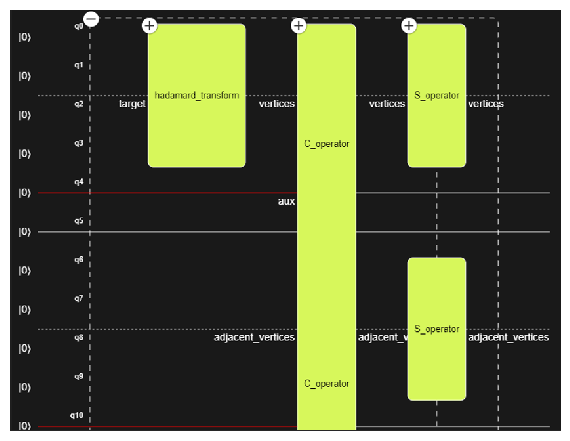

In [39]:
img = imshow('qwalk.png')
plt.axis('off')
plt.show()

(-0.5, 820.5, 639.5, -0.5)

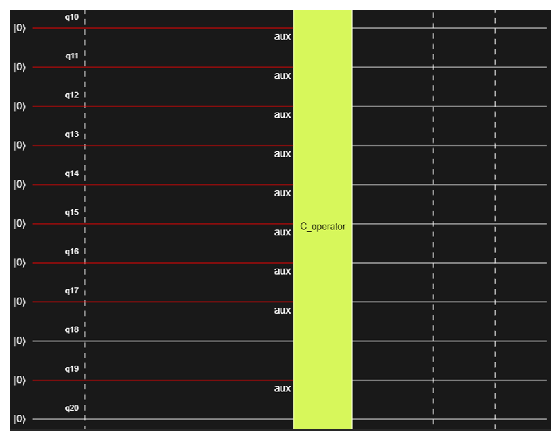

In [40]:
img1 = imshow('qwalk1.png')
plt.axis('off')

(-0.5, 683.5, 635.5, -0.5)

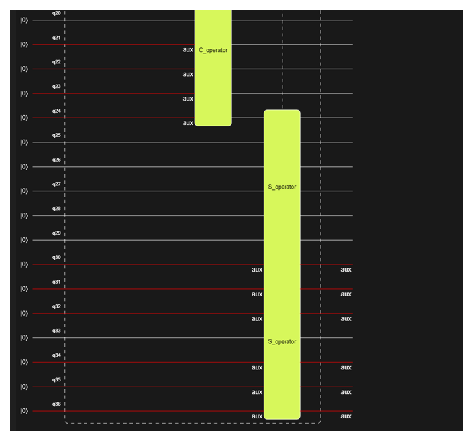

In [41]:
img2 = imshow('qw3.png')
plt.axis('off')